In [37]:
import math, random

import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

In [38]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

<h2>Replay Buffer</h2>

In [39]:
from collections import deque

class ReplayBuffer(object):
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        state      = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)

        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return np.concatenate(state), action, reward, np.concatenate(next_state), done

    def __len__(self):
        return len(self.buffer)

<h2>Cart Pole Environment</h2>

In [40]:
env_id = "CartPole-v1"
env = gym.make(env_id)

<h2>Epsilon greedy exploration</h2>

In [41]:
epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 500

epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)

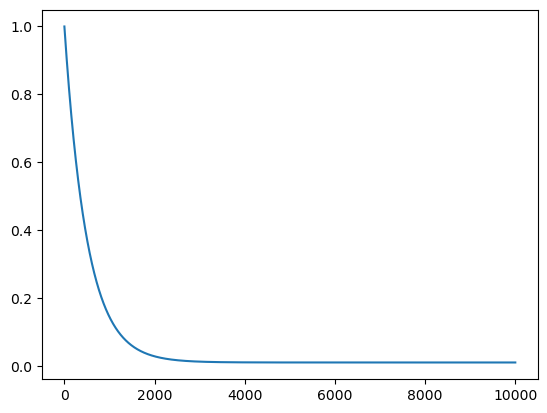

In [42]:
plt.plot([epsilon_by_frame(i) for i in range(10000)])

<h2>Deep Q Network</h2>

In [43]:
class DQN(nn.Module):
    def __init__(self, num_inputs, num_actions):
        super(DQN, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(num_inputs, 100),
            nn.ReLU(),
            nn.Linear(100, num_actions)
        )

    def forward(self, x):
        return self.layers(x)

    def act(self, state, epsilon):
        if random.random() > epsilon:
            state   = Variable(torch.FloatTensor(state).unsqueeze(0), volatile=True)
            q_value = self.forward(state)
            action  = q_value.max(1)[1].item()
        else:
            action = random.randrange(env.action_space.n)
        return action

In [44]:
model = DQN(env.observation_space.shape[0], env.action_space.n)

optimizer = optim.Adam(model.parameters())

replay_buffer = ReplayBuffer(1000)

<h2>Computing Temporal Difference Loss</h2>

In [45]:
def compute_td_loss(batch_size):
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)

    state      = Variable(torch.FloatTensor(np.float32(state)))
    next_state = Variable(torch.FloatTensor(np.float32(next_state)), volatile=True)
    action     = Variable(torch.LongTensor(action))
    reward     = Variable(torch.FloatTensor(reward))
    done       = Variable(torch.FloatTensor(done))

    q_values      = model(state)
    next_q_values = model(next_state)

    q_value          = q_values.gather(1, action.unsqueeze(1)).squeeze(1)
    next_q_value     = next_q_values.max(1)[0]
    expected_q_value = reward + gamma * next_q_value * (1 - done)

    loss = (q_value - Variable(expected_q_value.data)).pow(2).mean()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss

In [46]:
def plot(frame_idx, rewards, losses):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.show()

<h2>Training</h2>

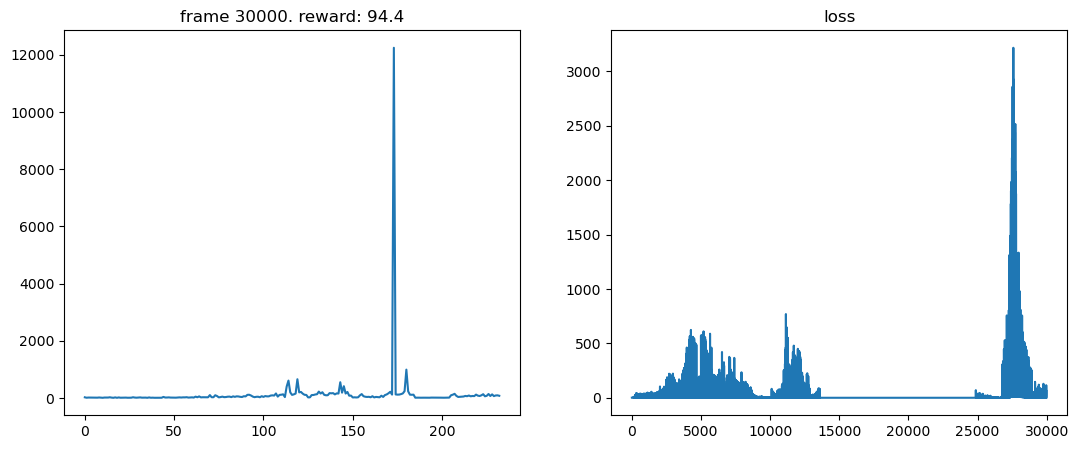

In [47]:
num_frames = 30000
batch_size = 32
gamma      = 0.99

losses = []
all_rewards = []
episode_reward = 0

state, _ = env.reset()
for frame_idx in range(1, num_frames + 1):
    epsilon = epsilon_by_frame(frame_idx)
    action = model.act(state, epsilon)

    next_state, reward, done, _, _ = env.step(action)
    replay_buffer.push(state, action, reward, next_state, done)

    state = next_state
    episode_reward += reward

    if done:
        state, _ = env.reset()
        all_rewards.append(episode_reward)
        episode_reward = 0

    if len(replay_buffer) > batch_size:
        loss = compute_td_loss(batch_size)
        losses.append(loss.item())

    if frame_idx % 200 == 0:
        plot(frame_idx, all_rewards, losses)

<h2>Dueling Deep Q Network</h2>

С учётом того что среда очень простая. Вы можете увидеть что награда в 200 очков сетью без dueling достигается быстрее.

In [48]:
class DuelingDQN(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(DuelingDQN, self).__init__()


        self.feature = nn.Sequential(
            nn.Linear(num_inputs, 128),
            nn.ReLU()
        )

        self.advantage = nn.Sequential(
            nn.Linear(128, 100),
            nn.ReLU(),
            nn.Linear(100, 1)
        )

        self.value = nn.Sequential(
            nn.Linear(128, 100),
            nn.ReLU(),
            nn.Linear(100, num_outputs)
        )

    def forward(self, x):
        x = self.feature(x)
        advantage = self.advantage(x)
        value     = self.value(x)
        return advantage + value

    def act(self, state, epsilon):
        if random.random() > epsilon:
            state   = Variable(torch.FloatTensor(state).unsqueeze(0), volatile=True)
            q_value = self.forward(state)
            action  = q_value.max(1)[1].item()
        else:
            action = random.randrange(env.action_space.n)
        return action

In [49]:
current_model = DuelingDQN(env.observation_space.shape[0], env.action_space.n)
target_model  = DuelingDQN(env.observation_space.shape[0], env.action_space.n)

optimizer = optim.Adam(current_model.parameters())

replay_buffer = ReplayBuffer(1000)

In [50]:
def update_target(current_model, target_model):
    target_model.load_state_dict(current_model.state_dict())

In [51]:
update_target(current_model, target_model)

In [52]:
def compute_td_loss(batch_size):
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)

    state      = Variable(torch.FloatTensor(np.float32(state)))
    next_state = Variable(torch.FloatTensor(np.float32(next_state)))
    action     = Variable(torch.LongTensor(action))
    reward     = Variable(torch.FloatTensor(reward))
    done       = Variable(torch.FloatTensor(done))

    q_values      = current_model(state)
    next_q_values = target_model(next_state)

    q_value          = q_values.gather(1, action.unsqueeze(1)).squeeze(1)
    next_q_value     = next_q_values.max(1)[0]
    expected_q_value = reward + gamma * next_q_value * (1 - done)

    loss = (q_value - expected_q_value.detach()).pow(2).mean()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss

In [53]:
def plot(frame_idx, rewards, losses):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.show()

<h2>Training</h2>

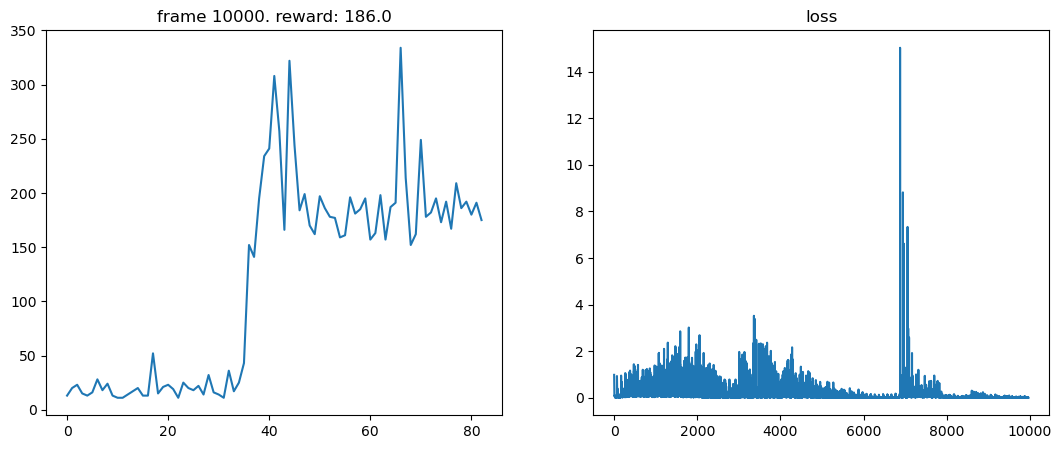

In [54]:
num_frames = 10000
batch_size = 32
gamma      = 0.99

losses = []
all_rewards = []
episode_reward = 0

state, _ = env.reset()
for frame_idx in range(1, num_frames + 1):
    epsilon = epsilon_by_frame(frame_idx)
    action = current_model.act(state, epsilon)

    next_state, reward, done, _, __ = env.step(action)
    replay_buffer.push(state, action, reward, next_state, done)

    state = next_state
    episode_reward += reward

    if done:
        state, _ = env.reset()
        all_rewards.append(episode_reward)
        episode_reward = 0

    if len(replay_buffer) > batch_size:
        loss = compute_td_loss(batch_size)
        losses.append(loss.item())

    if frame_idx % 200 == 0:
        plot(frame_idx, all_rewards, losses)

    if frame_idx % 100 == 0:
        update_target(current_model, target_model)
